# Implementação de Estimação de Fase
Implementação do algoritmo usando $QFT^{-1}$ para estimar o ângulo do autovalor de $\left|\ 1 \right\rangle$ em relação ao $Z^{1/8}$ para executar no IBM Q 5 Tenerife

In [128]:
# Import the Qiskit SDK
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import available_backends, execute, register, get_backend, compile
from qiskit.tools.visualization import plot_histogram, circuit_drawer
import time

pi = 3.14159265359

In [120]:
qx_config = {
        "APItoken": "4c79a44d415dcf5c0c967e7fb488a39c3c6042baacfd60861d6bca9326aeeb64022892979076e63e0bd6c6e007d4ef3d004b697a022bfaf469e8b0a999efdb63",
        "url":"https://quantumexperience.ng.bluemix.net/api"}

In [121]:
register(qx_config['APItoken'], qx_config['url'])
available_backends()

['ibmq_qasm_simulator',
 'ibmqx2',
 'ibmqx4',
 'ibmqx5',
 'local_qasm_simulator',
 'local_statevector_simulator',
 'local_unitary_simulator']

In [122]:
from qiskit import least_busy
least_busy(available_backends({'simulator': False}))

'ibmq_16_rueschlikon'

In [114]:
# couplingMap = [(0,1),(0,2),(1,2),(2,3),(4,2),(4,3)]
couplingMap = [(1,0),(2,0),(2,1),(3,2),(3,4),(4,2)]

def cRotation(qc, q, i, j, angle):
    
    half_a = angle / 2
    if i != 2 and j != 2:
        swap(qc, q, 2, j)
        cRotation(qc, q, i, 2, angle)
        swap(qc, q, 2, j)
    else:
        qc.u1(half_a, q[i])
        if(j,i) in couplingMap:
            qc.cx(q[j], q[i])
        else:
            invertCNOT(qc, q, i, j)
        qc.u1(-half_a, q[i])
        if(j,i) in couplingMap:
            qc.cx(q[j], q[i])
        else:
            invertCNOT(qc, q, i, j)
        qc.u1(half_a, q[j])
        
def invertCNOT(qc, q, i, j):
    qc.h(q[i])
    qc.h(q[j])
    qc.cx(q[i], q[j])
    qc.h(q[i])
    qc.h(q[j])
    
def swap(qc, q, i, j):
    if i != 2 and j != 2:
        swap(qc, q, 2, j)
        swap(qc, q, i, 2)
        swap(qc, q, 2, j)
    else:
        if (i,j) in couplingMap:
            qc.cx(q[i], q[j])  
            invertCNOT(qc, q, i, j)
            qc.cx(q[i], q[j])
        else:
            qc.cx(q[j], q[i])  
            invertCNOT(qc, q, j, i)
            qc.cx(q[j], q[i])
            
def inverse_qft(qc, q, indices):
        
    rev = list(reversed(indices))
    
    
    #swaps need to happen
    N = len(rev)
    
    for i in  range(int(N / 2)):
        j = N - i - 1
        swap(qc, q, i, j)
    
    for n, i in enumerate(rev):
        
        angle = -pi/2**n
        
        for j in rev[:n]:
            
            cRotation(qc, q, i, j, angle)
            angle *= 2
    
        qc.h(q[i])

In [115]:
# Create a Quantum Register with 5 qubits.
q = QuantumRegister(5)
# Create a Classical Register with 5 bits for storing results.
c = ClassicalRegister(5)
# Create a Quantum Circuit
qc = QuantumCircuit(q, c)

# Add a H gate on 4 qubits, putting the qubits in superposition.

qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.h(q[3])

#Put qubit to |1>
qc.x(q[4])

cRotation(qc, q, 3, 4, pi/8)

cRotation(qc, q, 2, 4, pi/4)

cRotation(qc, q, 1, 4, pi/2)

cRotation(qc, q, 0, 4, pi)

inverse_qft(qc, q, range(4))


qc.measure(q, c)

In [123]:
# See a list of available local simulators
print("Local backends: ", available_backends({'local': True}))

# Compile and run the Quantum circuit on a simulator backend
job = execute(qc, "local_qasm_simulator")

Local backends:  ['local_qasm_simulator', 'local_statevector_simulator', 'local_unitary_simulator']
Backends:  ['ibmq_qasm_simulator', 'ibmqx2', 'ibmqx4', 'ibmqx5', 'local_qasm_simulator', 'local_statevector_simulator', 'local_unitary_simulator']


KeyboardInterrupt: 

In [129]:
my_backend = get_backend('ibmqx4')
qobj = compile(qc, backend=my_backend, shots=1024)
job = my_backend.run(qobj)

lapse = 0
interval = 30
while not job.done:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status)
    time.sleep(interval)
    lapse += 1
print(job.status)

Status @ 0 seconds
{'job_id': None, 'status': <JobStatus.INITIALIZING: 'job is being initialized'>, 'status_msg': 'Job is initializing. Please, wait a moment.'}
Status @ 30 seconds
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 10}
Status @ 60 seconds
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 9}
Status @ 90 seconds
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 9}
Status @ 120 seconds
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 9}
Status @ 150 seconds
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 7}
Status @ 180 seconds
{'job_id': '5b7dd45c9d5b8

Got a 500 code response to https://quantumexperience.ng.bluemix.net/api/Jobs/5b7dd45c9d5b8200579f4f58?access_token=67b2UwQ3Es0eIFRjlurOKsP9wDATvXchazuwixlLPtRdXSItCSar8mdXvc3wxEYA: 500 Error: Failed to establish a backside connection


{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 3}
Status @ 300 seconds
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 3}
Status @ 330 seconds
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 2}
Status @ 360 seconds
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 1}
Status @ 390 seconds
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.RUNNING: 'job is actively running'>, 'status_msg': 'job is actively running'}
Status @ 420 seconds
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.DONE: 'job has successfully run'>, 'status_msg': 'job has successfully run'}
{'job_id': '5b7dd45c9d5b8200579f4f58', 'status': <JobStatus.DONE: 'j

In [132]:
result = job.result()
counts = result.get_counts()
print(result)
print(counts)

COMPLETED
{'10000': 36, '10001': 36, '10010': 44, '10011': 30, '10100': 14, '10101': 20, '10110': 17, '10111': 17, '11000': 31, '11001': 27, '11010': 19, '11011': 19, '11100': 38, '11101': 21, '11110': 29, '11111': 20, '00000': 61, '00001': 51, '00010': 69, '00011': 36, '00100': 27, '00101': 27, '00110': 36, '00111': 22, '01000': 41, '01001': 33, '01010': 27, '01011': 22, '01100': 54, '01101': 28, '01110': 49, '01111': 23}


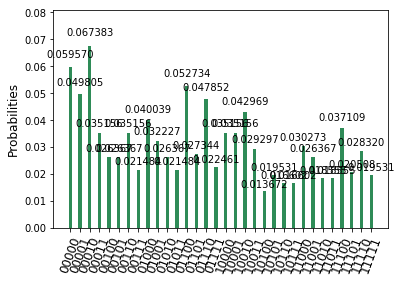

In [131]:
plot_histogram(counts)

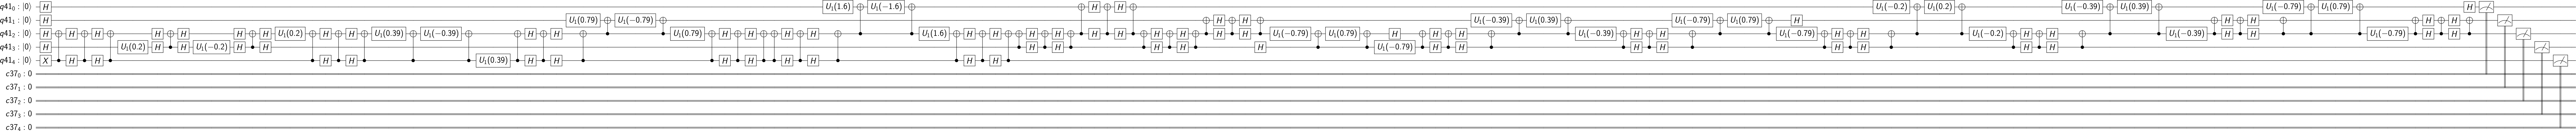

In [118]:
circuit_drawer(qc)

In [117]:
print(qc.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q41[5];
creg c37[5];
h q41[0];
h q41[1];
h q41[2];
h q41[3];
x q41[4];
cx q41[4],q41[2];
h q41[4];
h q41[2];
cx q41[4],q41[2];
h q41[4];
h q41[2];
cx q41[4],q41[2];
u1(0.196349540849375) q41[3];
h q41[3];
h q41[2];
cx q41[3],q41[2];
h q41[3];
h q41[2];
u1(-0.196349540849375) q41[3];
h q41[3];
h q41[2];
cx q41[3],q41[2];
h q41[3];
h q41[2];
u1(0.196349540849375) q41[2];
cx q41[4],q41[2];
h q41[4];
h q41[2];
cx q41[4],q41[2];
h q41[4];
h q41[2];
cx q41[4],q41[2];
u1(0.392699081698750) q41[2];
cx q41[4],q41[2];
u1(-0.392699081698750) q41[2];
cx q41[4],q41[2];
u1(0.392699081698750) q41[4];
cx q41[4],q41[2];
h q41[4];
h q41[2];
cx q41[4],q41[2];
h q41[4];
h q41[2];
cx q41[4],q41[2];
u1(0.785398163397500) q41[1];
cx q41[2],q41[1];
u1(-0.785398163397500) q41[1];
cx q41[2],q41[1];
u1(0.785398163397500) q41[2];
cx q41[4],q41[2];
h q41[4];
h q41[2];
cx q41[4],q41[2];
h q41[4];
h q41[2];
cx q41[4],q41[2];
cx q41[4],q41[2];
h q41[4];
h q41[2];
cx q41[4],q41